<a href="https://colab.research.google.com/github/mrbenbot/wimblepong/blob/main/Wimblepong_Reinforcement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
%pip install gym
%pip install stable-baselines3[extra]
%pip install tensorflowjs
%pip install onnx2tf onnx==1.15.0 onnxruntime==1.17.1 tensorflow==2.16.1

# onnx2tf deps:
%pip install onnx_graphsurgeon
%pip install sng4onnx

%pip install onnxscript

  Using cached onnx-1.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (15.7 MB)
  Attempting uninstall: onnx
    Found existing installation: onnx 1.16.1
    Uninstalling onnx-1.16.1:
      Successfully uninstalled onnx-1.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
onnxscript 0.1.0.dev20240627 requires onnx>=1.16, but you have onnx 1.15.0 which is incompatible.


  Using cached onnx-1.16.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (15.9 MB)
  Attempting uninstall: onnx
    Found existing installation: onnx 1.15.0
    Uninstalling onnx-1.15.0:
      Successfully uninstalled onnx-1.15.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

DRIVE_PATH = "/content/drive/MyDrive/wimblepong"
DAY = "26-thursday"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Import necessary libraries
import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.registration import register

import stable_baselines3
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize, VecCheckNan
from stable_baselines3.common.monitor import Monitor


from IPython import display

import os
import imageio
import glob
import math
import random
import subprocess


from IPython.display import display, Image, HTML

import tensorflow as tf
from tensorflow.keras import layers
import torch as th
import torch.onnx
import numpy as np
from onnx2tf import convert


import onnx

import matplotlib.pyplot as plt

from moviepy.editor import ImageSequenceClip
import pygame


# Check versions
print("gym version:", gym.__version__)
print("stable-baselines3 version:", stable_baselines3.__version__)


gym version: 0.29.1
stable-baselines3 version: 2.3.2


In [53]:
COURT_HEIGHT = 800
COURT_WIDTH = 1200
PADDLE_HEIGHT = 90
PADDLE_WIDTH = 15
BALL_RADIUS = 12
INITIAL_BALL_SPEED = 10
PADDLE_GAP = 10
PADDLE_SPEED_DIVISOR = 15  # Example value, adjust as needed
PADDLE_CONTACT_SPEED_BOOST_DIVISOR = 4  # Example value, adjust as needed
SPEED_INCREMENT = 0.6  # Example value, adjust as needed
SERVING_HEIGHT_MULTIPLIER = 2  # Example value, adjust as needed
PLAYER_COLOURS = {'Player1': 'red', 'Player2': 'blue'}
MAX_COMPUTER_PADDLE_SPEED = 15

In [3]:
rewards_map = {
    "hit_paddle": lambda _: 50,
    "score_point": lambda _: 100,
    "conceed_point": lambda ball, paddle, rally_length: (-abs(ball['y'] - paddle['y']) / max(rally_length, 1)),
    "serve": lambda ball_speed: ball_speed,
    "paddle_movement": lambda dy: 0,
    "ball_distance": lambda ball, paddle: 0
}

class Player:
    Player1 = 'Player1'
    Player2 = 'Player2'

class PlayerPositions:
    Initial = 'Initial'
    Reversed = 'Reversed'

class GameEventType:
    ResetBall = 'ResetBall'
    Serve = 'Serve'
    WallContact = 'WallContact'
    HitPaddle = 'HitPaddle'
    ScorePointLeft = 'ScorePointLeft'
    ScorePointRight = 'ScorePointRight'

def get_bounce_angle(paddle_y, paddle_height, ball_y):
    relative_intersect_y = (paddle_y + (paddle_height / 2)) - ball_y
    normalized_relative_intersect_y = relative_intersect_y / (paddle_height / 2)
    return normalized_relative_intersect_y * (math.pi / 4)

def bounded_value(value, min_value, max_value):
        return max(min_value, min(max_value, value))

In [7]:
class ComputerPlayer:
    def __init__(self):
        self.reset(serve_delay=50, initial_direction=15, offset=0, max_speed=MAX_COMPUTER_PADDLE_SPEED)

    def reset(self, serve_delay, initial_direction, offset, max_speed):
        # print("ComputerPlayer reset")
        self.serve_delay = serve_delay
        self.serve_delay_counter = 0
        self.direction = initial_direction
        self.offset = initial_direction
        self.max_speed = max_speed


    def get_actions(self, player, state):
        is_left = (player == Player.Player1 and not state['positions_reversed']) or (player == Player.Player2 and state['positions_reversed'])
        if state['ball']['score_mode']:
            return {'button_pressed': False, 'paddle_direction': 0}
        paddle = state[player]
        if state['ball']['serve_mode']:
            if paddle['y'] <= 0 or paddle['y'] + paddle['height'] >= COURT_HEIGHT:
                self.direction = -self.direction
            if self.serve_delay_counter > self.serve_delay:
                return {'button_pressed': True, 'paddle_direction': self.direction}
            else:
                self.serve_delay_counter += 1
                return {'button_pressed': False, 'paddle_direction': self.direction}
        if is_left:
            return {
                'button_pressed': False,
                'paddle_direction': bounded_value(
                    paddle['y'] + self.offset - state['ball']['y'] + paddle['height'] / 2,
                    -MAX_COMPUTER_PADDLE_SPEED,
                    MAX_COMPUTER_PADDLE_SPEED
                )
            }
        else:
            return {
                'button_pressed': False,
                'paddle_direction': -bounded_value(
                    paddle['y'] + self.offset - state['ball']['y'] + paddle['height'] / 2  ,
                    -MAX_COMPUTER_PADDLE_SPEED,
                    MAX_COMPUTER_PADDLE_SPEED
                )
            }


In [46]:
class RewardSystem:
    def __init__(self, rewarded_player):
        self.rewarded_player = rewarded_player
        self.total_reward = 0
        self.step_count = 0

    def reset(self):
        self.total_reward = 0
        self.step_count += 1

    def pre_serve_reward(self, player, game_state):
        if player == self.rewarded_player:
            self.total_reward -= 0.01
            # if self.step_count > 150:
            #   self.total_reward -= self.step_count * 0.02
            # else:
            #   ball = game_state['ball']
            #   reward = (abs(ball['dy']) * ((1000 - self.step_count) / 1000)) / 10
            #   self.total_reward += reward

    def serve_reward(self, player, game_state):
        if player == self.rewarded_player:
            ball = game_state['ball']
            reward = abs(ball['dy']) * abs(ball['dy'])
            self.total_reward += reward

    def hit_paddle_reward(self, player, game_state):
        if player == self.rewarded_player:
            reward = 50
            self.total_reward += reward

    def conceed_point_reward(self, player, game_state):
        if player == self.rewarded_player:
            reward = (-abs(game_state['ball']['y'] - game_state[player]['y']) / max(game_state['stats']['rally_length'], 1))
            self.total_reward += reward

    def score_point_reward(self, player, game_state):
        if player == self.rewarded_player:
            reward = 100
            self.total_reward += reward

    def paddle_movement_reward(self, player, game_state):
        if player == self.rewarded_player:
            paddle = game_state[player]
            reward = 0
            self.total_reward += reward


In [29]:
class PongGame:
    def __init__(self, server, positions_reversed, player, opponent):
        self.game_state = {
        'server': server,
        'positions_reversed': positions_reversed,
        'player': player,
        'opponent': opponent,
        Player.Player1: {'x': PADDLE_GAP, 'y': COURT_HEIGHT // 2 - PADDLE_HEIGHT // 2, 'dy': 0, 'width': PADDLE_WIDTH, 'height': PADDLE_HEIGHT, 'colour': 'blue'},
        Player.Player2: {'x': COURT_WIDTH - PADDLE_WIDTH - PADDLE_GAP, 'y': COURT_HEIGHT // 2 - PADDLE_HEIGHT // 2, 'dy': 0, 'width': PADDLE_WIDTH, 'height': PADDLE_HEIGHT, 'colour': 'red'},
        'ball': {'x': COURT_WIDTH // 2, 'y': COURT_HEIGHT // 2, 'dx': INITIAL_BALL_SPEED, 'dy': INITIAL_BALL_SPEED, 'radius': BALL_RADIUS, 'speed': INITIAL_BALL_SPEED, 'serve_mode': True, 'score_mode': False, 'score_mode_timeout': 0},
        'stats': {'rally_length': 0, 'serve_speed': INITIAL_BALL_SPEED, 'server': server}
        }
        self.apply_meta_game_state()

    def apply_meta_game_state(self):
        game_state = self.game_state
        serving_player = game_state['server']
        positions_reversed = game_state['positions_reversed']
        if serving_player == Player.Player1:
            self.game_state[Player.Player1]['height'] = PADDLE_HEIGHT * SERVING_HEIGHT_MULTIPLIER
            self.game_state[Player.Player2]['height'] = PADDLE_HEIGHT
        else:
            self.game_state[Player.Player1]['height'] = PADDLE_HEIGHT
            self.game_state[Player.Player2]['height'] = PADDLE_HEIGHT * SERVING_HEIGHT_MULTIPLIER
        if positions_reversed:
            self.game_state[Player.Player1]['x'] = COURT_WIDTH - PADDLE_WIDTH - PADDLE_GAP
            self.game_state[Player.Player2]['x'] = PADDLE_GAP
        else:
            self.game_state[Player.Player1]['x'] = PADDLE_GAP
            self.game_state[Player.Player2]['x'] = COURT_WIDTH - PADDLE_WIDTH - PADDLE_GAP
        ball = self.game_state['ball']
        server_is_left = (serving_player == Player.Player1 and not positions_reversed) or (serving_player == Player.Player2 and positions_reversed)
        ball['y'] = self.game_state[serving_player]['height'] / 2 + self.game_state[serving_player]['y']
        ball['x'] = self.game_state[serving_player]['width'] + ball['radius'] + PADDLE_GAP if server_is_left else COURT_WIDTH - self.game_state[serving_player]['width'] - ball['radius'] - PADDLE_GAP
        ball['speed'] = INITIAL_BALL_SPEED
        ball['serve_mode'] = True
        ball['score_mode'] = False
        ball['score_mode_timeout'] = 0
        self.game_state['stats']['rally_length'] = 0

    def update_game_state(self, actions, delta_time, reward_system):
        reward = 0
        game_state = self.game_state
        ball = game_state['ball']
        stats = game_state['stats']
        server = game_state['server']
        paddle_left, paddle_right = (game_state[Player.Player2], game_state[Player.Player1]) if game_state['positions_reversed'] else (game_state[Player.Player1], game_state[Player.Player2])
        player_is_left = (game_state['player'] == Player.Player1 and not game_state['positions_reversed']) or (game_state['player'] == Player.Player2 and game_state['positions_reversed'])
        if ball['score_mode']:
            return True
        elif ball['serve_mode']:
            serving_from_left = (server == Player.Player1 and not game_state['positions_reversed']) or (server == Player.Player2 and game_state['positions_reversed'])

            reward_system.pre_serve_reward(server, game_state)

            if actions[server]['button_pressed']:
                ball['speed'] = INITIAL_BALL_SPEED
                ball['dx'] = INITIAL_BALL_SPEED if serving_from_left else -INITIAL_BALL_SPEED
                ball['serve_mode'] = False
                stats['rally_length'] += 1
                stats['serve_speed'] = abs(ball['dy']) + abs(ball['dx'])
                stats['server'] = server

                reward_system.serve_reward(server, game_state)

            ball['dy'] = (game_state[server]['y'] + game_state[server]['height'] / 2 - ball['y']) / PADDLE_SPEED_DIVISOR
            ball['y'] += ball['dy'] * delta_time
        else:
            ball['x'] += ball['dx'] * delta_time
            ball['y'] += ball['dy'] * delta_time
            if ball['y'] - ball['radius'] < 0:
                ball['dy'] = -ball['dy']
                ball['y'] = ball['radius']
            elif ball['y'] + ball['radius'] > COURT_HEIGHT:
                ball['dy'] = -ball['dy']
                ball['y'] = COURT_HEIGHT - ball['radius']
            if ball['x'] - ball['radius'] < paddle_left['x'] + paddle_left['width'] and ball['y'] + ball['radius'] > paddle_left['y'] and ball['y'] - ball['radius'] < paddle_left['y'] + paddle_left['height']:
                bounce_angle = get_bounce_angle(paddle_left['y'], paddle_left['height'], ball['y'])
                ball['dx'] = (ball['speed'] + abs(paddle_left['dy']) / PADDLE_CONTACT_SPEED_BOOST_DIVISOR) * math.cos(bounce_angle)
                ball['dy'] = (ball['speed'] + abs(paddle_left['dy']) / PADDLE_CONTACT_SPEED_BOOST_DIVISOR) * -math.sin(bounce_angle)
                ball['x'] = paddle_left['x'] + paddle_left['width'] + ball['radius']
                ball['speed'] += SPEED_INCREMENT
                stats['rally_length'] += 1

                if paddle_left == game_state['player']:
                    reward_system.hit_paddle_reward(self.game_state['player'], game_state)

            elif ball['x'] + ball['radius'] > paddle_right['x'] and ball['y'] + ball['radius'] > paddle_right['y'] and ball['y'] - ball['radius'] < paddle_right['y'] + paddle_right['height']:
                bounce_angle = get_bounce_angle(paddle_right['y'], paddle_right['height'], ball['y'])
                ball['dx'] = -(ball['speed'] + abs(paddle_right['dy']) / PADDLE_CONTACT_SPEED_BOOST_DIVISOR) * math.cos(bounce_angle)
                ball['dy'] = (ball['speed'] + abs(paddle_right['dy']) / PADDLE_CONTACT_SPEED_BOOST_DIVISOR) * -math.sin(bounce_angle)
                ball['x'] = paddle_right['x'] - ball['radius']
                ball['speed'] += SPEED_INCREMENT
                stats['rally_length'] += 1

                if paddle_right == game_state['player']:
                    reward_system.hit_paddle_reward(self.game_state['player'], game_state)

            if ball['x'] - ball['radius'] < 0:
                ball['score_mode'] = True

                if player_is_left:
                    reward_system.conceed_point_reward(self.game_state['player'], game_state)
                else:
                    reward_system.score_point_reward(self.game_state['player'], game_state)

            elif ball['x'] + ball['radius'] > COURT_WIDTH:
                ball['score_mode'] = True

                if not player_is_left:
                    reward_system.conceed_point_reward(self.game_state['player'], game_state)
                else:
                    reward_system.score_point_reward(self.game_state['player'], game_state)

        if game_state['positions_reversed']:
            game_state[Player.Player1]['dy'] = actions[Player.Player1]['paddle_direction']
            game_state[Player.Player2]['dy'] = -actions[Player.Player2]['paddle_direction']
        else:
            game_state[Player.Player1]['dy'] = -actions[Player.Player1]['paddle_direction']
            game_state[Player.Player2]['dy'] = actions[Player.Player2]['paddle_direction']

        game_state[Player.Player1]['y'] += game_state[Player.Player1]['dy'] * delta_time
        game_state[Player.Player2]['y'] += game_state[Player.Player2]['dy'] * delta_time

        if paddle_left['y'] < 0:
            paddle_left['y'] = 0
        if paddle_left['y'] + paddle_left['height'] > COURT_HEIGHT:
            paddle_left['y'] = COURT_HEIGHT - paddle_left['height']
        if paddle_right['y'] < 0:
            paddle_right['y'] = 0
        if paddle_right['y'] + paddle_right['height'] > COURT_HEIGHT:
            paddle_right['y'] = COURT_HEIGHT - paddle_right['height']

        reward_system.paddle_movement_reward(self.game_state['player'], game_state)
        return False

In [100]:
class CustomPongEnv(gym.Env):
    def __init__(self, computer_player):
        super(CustomPongEnv, self).__init__()

        self.action_space = spaces.Box(low=np.array([0, -1]), high=np.array([1, 1]), dtype=np.float32)
        self.observation_space = spaces.Box(
            low=np.array([0, 0, -1, -1, 0, 0, 0, 0], dtype=np.float32),
            high=np.array([1, 1, 1, 1, 1, 1, 1, 1], dtype=np.float32)
        )
        self.starting_states = [
           {'server': Player.Player1, 'positions_reversed': False, 'opponent': Player.Player1, 'player': Player.Player2},
           {'server': Player.Player2, 'positions_reversed': False, 'opponent': Player.Player1, 'player': Player.Player2},
           {'server': Player.Player2, 'positions_reversed': True, 'opponent': Player.Player1, 'player': Player.Player2},
           {'server': Player.Player1, 'positions_reversed': True, 'opponent': Player.Player1, 'player': Player.Player2},
        ]
        self.starting_state_index = 0

        self.computer_player = computer_player
        self.screen = None
        self.frame_count = 0
        self.last_event = None
        self.reset(seed=0)

    def seed(self, seed=None):
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        return [seed]

    def reset(self, seed=None):
        super().reset(seed=seed)
        if seed is not None:
            self.seed(seed)
        # print("CustomPongEnv reset")
        self.starting_state_index = (self.starting_state_index + 1) % len(self.starting_states)
        # print(self.starting_state_index)
        starting_state = self.starting_states[self.starting_state_index]

        server = starting_state['server']
        positions_reversed = starting_state['positions_reversed']
        player = starting_state['player']
        opponent = starting_state['opponent']
        self.computer_player.reset(serve_delay=random.randint(10, 10), initial_direction=random.randint(-60, 60), offset=random.randint(-PADDLE_HEIGHT/2, PADDLE_HEIGHT/2), max_speed=MAX_COMPUTER_PADDLE_SPEED)
        self.game = PongGame(server=server, positions_reversed=positions_reversed, opponent=opponent, player=player)
        self.reward_system = RewardSystem(rewarded_player=player)
        self.step_count = 0

        return self._get_obs(), {}

    def step(self, action):
        # print(f"Action taken: {action}")
        self.step_count += 1
        self.reward_system.reset()
        button_pressed = action[0] > 0.5
        paddle_direction = action[1]
        model_player_actions = {'button_pressed': button_pressed, 'paddle_direction': paddle_direction * 60}
        computer_player_actions = self.computer_player.get_actions(self.game.game_state['opponent'], self.game.game_state)
        actions = {self.game.game_state['opponent']: computer_player_actions, self.game.game_state['player']: model_player_actions}
        terminated = self.game.update_game_state(actions, 2.5, self.reward_system)
        obs = self._get_obs()
        info = {}
        truncated = False
        if self.step_count > 1000:
            terminated = True
        reward = self.reward_system.total_reward
        return obs, reward, terminated, truncated, info

    def _get_obs(self):
        state = self.game.game_state
        player = state['player']
        is_server = 1 if self.game.game_state['server'] == player else 0
        paddle = state[player]
        obs = np.array([
            float(state['ball']['x'] / COURT_WIDTH),
            float(state['ball']['y'] / COURT_HEIGHT),
            float(state['ball']['dx'] / 40),
            float(state['ball']['dy'] / 40),
            float(0 if paddle['x'] < COURT_WIDTH / 2 else 1),
            float(paddle['y'] / COURT_HEIGHT),
            float(int(state['ball']['serve_mode'])),
            float(int(is_server)),
        ], dtype=np.float32)
        return obs

    def render(self, mode='human', close=False):
        if close:
            if pygame.get_init():
                pygame.quit()
            return

        if self.screen is None:
            pygame.init()
            self.screen = pygame.display.set_mode((COURT_WIDTH, COURT_HEIGHT))
        if not os.path.exists('./frames'):
            os.makedirs("./frames")

        # Clear screen
        self.screen.fill((255, 255, 255))  # Fill with white background
        state = self.game.game_state
        # Render paddles
        paddle1 = state[Player.Player1]
        paddle2 = state[Player.Player2]
        pygame.draw.rect(self.screen, paddle1['colour'], (paddle1['x'], paddle1['y'], paddle1['width'], paddle1['height']))
        pygame.draw.rect(self.screen, paddle2['colour'], (paddle2['x'], paddle2['y'], paddle2['width'], paddle2['height']))

        # Render ball
        ball = state['ball']
        pygame.draw.circle(self.screen, (0, 0, 0), (ball['x'], ball['y']), ball['radius'])

        # Update the display
        pygame.display.flip()

        # Save frame as image
        frame_path = f'./frames/frame_{self.frame_count:04d}.png'
        pygame.image.save(self.screen, frame_path)
        self.frame_count += 1


    def close(self):
        if not os.path.exists('./frames'):
            print("No frames directory found, skipping video creation.")
            return
        image_files = [f"./frames/frame_{i:04d}.png" for i in range(self.frame_count)]

        # Create a video clip from the image sequence
        clip = ImageSequenceClip(image_files, fps=24)  # 24 frames per second

        # Write the video file
        clip.write_videofile("./game_video.mp4", codec="libx264")
        pygame.quit()
        frames_dir = "./frames"
        if os.path.exists(frames_dir):
            for filename in os.listdir(frames_dir):
                file_path = os.path.join(frames_dir, filename)
                if os.path.isfile(file_path):
                    os.unlink(file_path)
            os.rmdir(frames_dir)


register(
    id='CustomPongEnv-v0',
    entry_point='__main__:CustomPongEnv',  # This entry point should match your custom environment class
)


In [20]:
# Create and test vectorised environment
# Create a vectorized environment
env = DummyVecEnv([lambda: CustomPongEnv(computer_player=ComputerPlayer()) for _ in range(1)])  # Adjust number of instances as needed
env = VecNormalize(env, norm_obs=False, norm_reward=True)  # Normalize observations and rewards
# env = VecCheckNan(env, raise_exception=True)  # Wrap with VecCheckNan to detect NaNs


obs = env.reset()
print("Initial observation:", obs)

for i in range(10000000):
    action = env.action_space.sample()  # Sample random action
    print("Action taken:", action)
    obs, reward, done, info = env.step([action for _ in range(1)])
    print("Observation:", obs)
    print("Reward:", reward)
    print('iteration:', i)
    print("Done:", done)
    if np.any(done):
        obs = env.reset()
        break
        print("Environment reset")

env.close()

Initial observation: [[0.9691667 0.55625   0.25      0.25      1.        0.44375   1.
  1.       ]]
Action taken: [ 0.15970048 -0.43001705]
Observation: [[0.9691667 0.55625   0.25      0.        1.        0.3631218 1.
  1.       ]]
Reward: [10.]
iteration: 0
Done: [False]
Action taken: [0.9213258 0.6158111]
Observation: [[ 0.9691667   0.542812   -0.25       -0.10750426  1.          0.47858638
   0.          1.        ]]
Reward: [2.0143578]
iteration: 1
Done: [False]
Action taken: [ 0.92651963 -0.37926456]
Observation: [[ 0.9483333   0.52937394 -0.25       -0.10750426  1.          0.40747428
   0.          1.        ]]
Reward: [0.93832016]
iteration: 2
Done: [False]
Action taken: [0.04438894 0.39902732]
Observation: [[ 0.9275      0.5159359  -0.25       -0.10750426  1.          0.4822919
   0.          1.        ]]
Reward: [0.7932152]
iteration: 3
Done: [False]
Action taken: [ 0.7562352  -0.08482796]
Observation: [[ 0.9066667   0.50249785 -0.25       -0.10750426  1.          0.46638665


In [74]:

# Create and test single environment
env = Monitor(CustomPongEnv(computer_player=ComputerPlayer()))

obs = env.reset()
print("Initial observation:", obs)

for i in range(1000):
    action = env.action_space.sample()  # Sample random action
    obs, reward, done, info, _ = env.step(action)
    print("Action taken:", action)
    print("Observation:", obs)
    print("Reward:", reward)
    print('iteration:', i)
    print("Done:", done)
    env.render()
    if done:
        obs = env.reset()
        print("Environment reset")
        break

env.close()

Initial observation: (array([0.9691667, 0.55625  , 0.25     , 0.25     , 1.       , 0.44375  ,
       1.       , 1.       ], dtype=float32), {})
Action taken: [ 0.9963445  -0.11009466]
Observation: [ 0.9691667   0.55625    -0.25        0.          1.          0.42310724
  0.          1.        ]
Reward: 2.01
iteration: 0
Done: False
Action taken: [ 0.41906592 -0.79476184]
Observation: [ 0.9483333  0.55625   -0.25       0.         1.         0.2740894
  0.         1.       ]
Reward: 0.01
iteration: 1
Done: False
Action taken: [0.9478894  0.87098277]
Observation: [ 0.9275      0.55625    -0.25        0.          1.          0.43739867
  0.          1.        ]
Reward: 0.01
iteration: 2
Done: False
Action taken: [0.93524736 0.6148688 ]
Observation: [ 0.9066667  0.55625   -0.25       0.         1.         0.5526866
  0.         1.       ]
Reward: 0.01
iteration: 3
Done: False
Action taken: [ 0.4522378 -0.5251924]
Observation: [ 0.8858333  0.55625   -0.25       0.         1.         0.45421

Moviepy - Done !
Moviepy - video ready ./game_video.mp4


In [22]:

class CustomEvalCallback(EvalCallback):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mean_rewards = []

    def _on_step(self) -> bool:
        result = super()._on_step()
        if self.n_calls % self.eval_freq == 0:
            print(f"Evaluation at step {self.n_calls}: mean reward {self.last_mean_reward:.2f}")
            self.mean_rewards.append(self.last_mean_reward)
        return result

Using cuda device
Eval num_timesteps=8000, episode_reward=-10.01 +/- 0.00
Episode length: 1001.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -10      |
| time/              |          |
|    total_timesteps | 8000     |
---------------------------------
New best mean reward!
Evaluation at step 2000: mean reward -10.01
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 99.8     |
|    ep_rew_mean     | 2.68     |
| time/              |          |
|    fps             | 1155     |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 8192     |
---------------------------------
Eval num_timesteps=16000, episode_reward=-10.01 +/- 0.00
Episode length: 1001.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | -10  

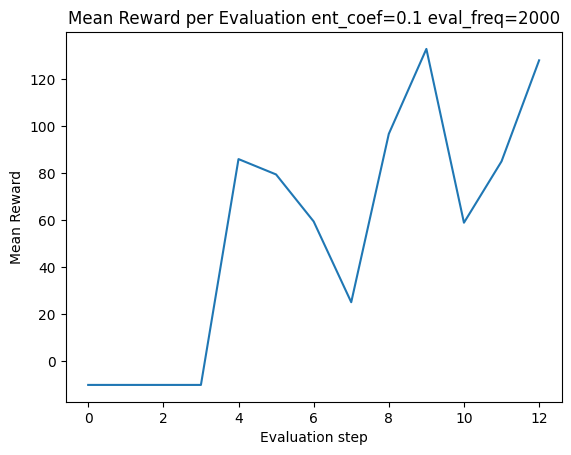

In [44]:
# Create and train
ent_coef=0.1
eval_freq=2000
gamma=0.95
# Create vectorized environments for training and evaluation
train_env = DummyVecEnv([lambda: Monitor(CustomPongEnv(computer_player=ComputerPlayer())) for _ in range(4)])
train_env = VecNormalize(train_env, norm_obs=False, norm_reward=True)

eval_env = DummyVecEnv([lambda: Monitor(CustomPongEnv(computer_player=ComputerPlayer()))])
eval_env = VecNormalize(eval_env, norm_obs=False, norm_reward=False)

# Create the CustomEvalCallback
eval_callback = CustomEvalCallback(eval_env, best_model_save_path=f'{DRIVE_PATH}/{DAY}/logs/best_model',
                                   log_path=f'{DRIVE_PATH}/{DAY}/logs/results', eval_freq=eval_freq,
                                   deterministic=True, render=False)

# Train the model with the callback
model = PPO('MlpPolicy', train_env, verbose=1, ent_coef=ent_coef, gamma=gamma)
model.learn(total_timesteps=100000, callback=eval_callback, progress_bar=False)

# Save the model
model.save(f"{DRIVE_PATH}/{DAY}/ppo_custom_pong_1")

print("Training completed and logs are saved.")

# Plot the mean rewards
plt.plot(eval_callback.mean_rewards)
plt.xlabel('Evaluation step')
plt.ylabel('Mean Reward')
plt.title(f'Mean Reward per Evaluation {ent_coef=} {eval_freq=}')
plt.show()

Eval num_timesteps=8000, episode_reward=60.90 +/- 177.47
Episode length: 91.00 +/- 51.85
---------------------------------
| eval/              |          |
|    mean_ep_length  | 91       |
|    mean_reward     | 60.9     |
| time/              |          |
|    total_timesteps | 8000     |
---------------------------------
New best mean reward!
Evaluation at step 2000: mean reward 60.90
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 88.9     |
|    ep_rew_mean     | -155     |
| time/              |          |
|    fps             | 2511     |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 8192     |
---------------------------------
Eval num_timesteps=16000, episode_reward=-36.31 +/- 375.27
Episode length: 80.60 +/- 24.43
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 80.6         |
|    mean_reward          | -36.3        |
| tim

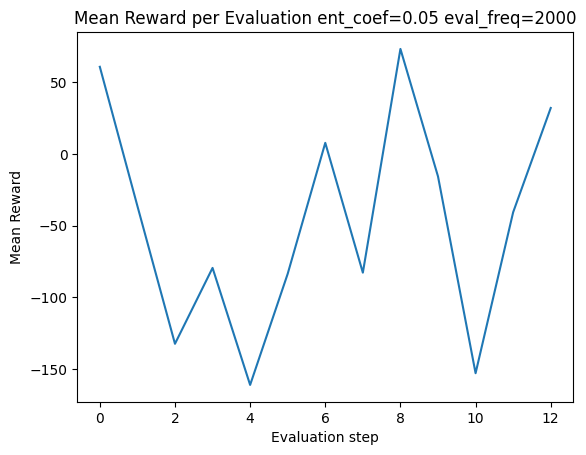

In [56]:
# Load and train
ent_coef=0.05
gamma=0.999
eval_freq=2000
# Load the trained model and ensure the training environment is wrapped with VecNormalize
train_env = DummyVecEnv([lambda: Monitor(CustomPongEnv(computer_player=ComputerPlayer())) for _ in range(4)])
train_env = VecNormalize(train_env, norm_obs=False, norm_reward=True)
train_env.training = True  # Ensure it's in training mode

# Create the evaluation environment and wrap it with VecNormalize
eval_env = DummyVecEnv([lambda: Monitor(CustomPongEnv(computer_player=ComputerPlayer()))])
eval_env = VecNormalize(eval_env, norm_obs=False, norm_reward=False)
eval_env.training = False  # Ensure it's not in training mode


# Create the CustomEvalCallback with the evaluation environment
eval_callback = CustomEvalCallback(eval_env, best_model_save_path=f'{DRIVE_PATH}/{DAY}/logs/best_model',
                                   log_path=f'{DRIVE_PATH}/{DAY}/logs/results', eval_freq=eval_freq,
                                   deterministic=True, render=False)

# Load the pre-trained model
# model = PPO.load(f"{DRIVE_PATH}/{DAY}/ppo_custom_pong_1", env=train_env, ent_coef=ent_coef, gamma=gamma)
model = PPO.load(f"{DRIVE_PATH}/{DAY}/logs/best_model/best_model", env=train_env, ent_coef=ent_coef, gamma=gamma)

# Resume training the model with the callback
model.learn(total_timesteps=100000, callback=eval_callback)

# Save the model and the normalization statistics
model.save(f"{DRIVE_PATH}/{DAY}/ppo_custom_pong_1")

print("Training completed and logs are saved.")

# Plot the mean rewards
plt.plot(eval_callback.mean_rewards)
plt.xlabel('Evaluation step')
plt.ylabel('Mean Reward')
plt.title(f'Mean Reward per Evaluation {ent_coef=} {eval_freq=}')
plt.show()

In [ ]:
model = PPO.load(f"{DRIVE_PATH}/{DAY}/ppo_custom_pong_1")
# Evaluate the trained model
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward} +/- {std_reward}")

Mean reward: -78.79866129999999 +/- 133.82650038538142


In [96]:
# Load the trained model and evaluate
model = PPO.load(f"{DRIVE_PATH}/{DAY}/ppo_custom_pong_1")
# model = PPO.load(f"{DRIVE_PATH}/{DAY}/logs/best_model/best_model")

# Create a new environment for rendering
eval_env = DummyVecEnv([lambda: CustomPongEnv(computer_player=ComputerPlayer())])
eval_env = VecNormalize(eval_env, norm_obs=False, norm_reward=False)
eval_env.training = False  # Ensure we're not in training mode to prevent normalization updates


# Extract the first environment from the vectorized environment
env = eval_env.envs[0]

# Run a simple loop to demonstrate rendering with the trained model
obs = eval_env.reset()
count = 0

while count < 4:
    action, _states = model.predict(obs, deterministic=True)  # Get action from the trained model
    # print(obs, action)
    obs, reward, done, info = eval_env.step(action)
    env.render()
    if done:
      count += 1
      print("reset")
      obs = eval_env.reset()
      env.reset()

env.close()

reset
reset
reset
reset
Moviepy - Building video ./game_video.mp4.
Moviepy - Writing video ./game_video.mp4



Moviepy - Done !
Moviepy - video ready ./game_video.mp4


In [9]:
import torch as th
from typing import Tuple
from stable_baselines3 import PPO
from stable_baselines3.common.policies import BasePolicy
import onnx
import onnxruntime as ort
import numpy as np

class OnnxableSB3Policy(th.nn.Module):
    def __init__(self, policy: BasePolicy):
        super().__init__()
        self.policy = policy

    def forward(self, observation: th.Tensor) -> Tuple[th.Tensor, th.Tensor, th.Tensor]:
        # Run the policy in deterministic mode
        actions, values, log_prob = self.policy(observation, deterministic=True)
        return actions, values, log_prob


# Load the trained PyTorch model
model_path = f"{DRIVE_PATH}/{DAY}/ppo_custom_pong_1"
model = PPO.load(model_path, device="cpu")

onnx_policy = OnnxableSB3Policy(model.policy)

# Define dummy input based on the observation space shape
observation_size = model.observation_space.shape
dummy_input = th.randn(1, *observation_size)
onnx_file_path = f"{DRIVE_PATH}/{DAY}/ppo_custom_pong_dynamo.onnx"

# Export the model to ONNX
th.onnx.export(
    onnx_policy,
    dummy_input,
    onnx_file_path,
    opset_version=11,
    input_names=["input"],
    output_names=["actions", "values", "log_prob"]
)

# Load the ONNX model
onnx_model = onnx.load(onnx_file_path)
onnx.checker.check_model(onnx_model)

# Prepare a dummy observation for testing
observation = np.zeros((1, *observation_size)).astype(np.float32)

# Create an ONNX runtime session
ort_sess = ort.InferenceSession(onnx_file_path)
ort_inputs = {"input": observation}
ort_outputs = ort_sess.run(None, ort_inputs)

# Output from ONNX
onnx_actions, onnx_values, onnx_log_prob = ort_outputs

# Print ONNX outputs
print("ONNX Actions:", onnx_actions)
print("ONNX Values:", onnx_values)
print("ONNX Log Prob:", onnx_log_prob)

# Check that the predictions are the same in PyTorch
with th.no_grad():
    pytorch_outputs = onnx_policy(th.as_tensor(observation))

# Print PyTorch outputs
print("PyTorch Actions:", pytorch_outputs[0].numpy())
print("PyTorch Values:", pytorch_outputs[1].numpy())
print("PyTorch Log Prob:", pytorch_outputs[2].numpy())

# Comparison function
def compare_outputs(pytorch_outputs, onnx_outputs):
    pytorch_actions, pytorch_values, pytorch_log_prob = [output.numpy() for output in pytorch_outputs]
    onnx_actions, onnx_values, onnx_log_prob = onnx_outputs

    actions_match = np.allclose(pytorch_actions, onnx_actions, atol=1e-5)
    values_match = np.allclose(pytorch_values, onnx_values, atol=1e-5)
    log_prob_match = np.allclose(pytorch_log_prob, onnx_log_prob, atol=1e-5)

    print(f"Actions match: {actions_match}")
    print(f"Values match: {values_match}")
    print(f"Log prob match: {log_prob_match}")

# Compare the outputs
compare_outputs(pytorch_outputs, ort_outputs)


ONNX Actions: [[-15.044194 370.17538 ]]
ONNX Values: [[-6.150612]]
ONNX Log Prob: [-31.393408]
PyTorch Actions: [[-15.044194 370.17535 ]]
PyTorch Values: [[-6.150613]]
PyTorch Log Prob: [-31.393408]
Actions match: True
Values match: True
Log prob match: True


In [8]:
from onnx2tf import convert

# Define paths
tf_model_path = f"{DRIVE_PATH}/{DAY}/ppo_custom_pong_1_tf"

# Convert ONNX to TensorFlow SavedModel
convert(
    input_onnx_file_path=onnx_file_path,
    output_folder_path=tf_model_path,
    output_signaturedefs=True,
)



Model optimizing started ============================================================
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/onnx2tf/onnx2tf.py", line 631, in convert
    result = subprocess.check_output(
  File "/usr/lib/python3.10/subprocess.py", line 421, in check_output
    return run(*popenargs, stdout=PIPE, timeout=timeout, check=True,
  File "/usr/lib/python3.10/subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "/usr/lib/python3.10/subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "/usr/lib/python3.10/subprocess.py", line 1863, in _execute_child
    raise child_exception_type(errno_num, err_msg, err_filename)
FileNotFoundError: [Errno 2] No such file or directory: 'onnxsim'


Automatic generation of each OP name started ========================================
Automatic generation of each OP name complete!

Model loaded =================

In [99]:
# Define paths
tfjs_model_path = f"{DRIVE_PATH}/{DAY}/ppo_custom_pong_1_tfjs_2"

# Convert the TensorFlow model to TensorFlow.js
subprocess.run([
    'tensorflowjs_converter',
    '--input_format', 'tf_saved_model',
    '--output_format', 'tfjs_graph_model',
    "--signature_name", "serving_default",
    tf_model_path,
    tfjs_model_path
])

print(f"TensorFlow.js model saved at: {tfjs_model_path}")


TensorFlow.js model saved at: /content/drive/MyDrive/wimblepong/26-thursday/ppo_custom_pong_1_tfjs_2
